# Reinforcement Learning: Zero to Hero - Part 15/17

**Cells 241-260 of 291**



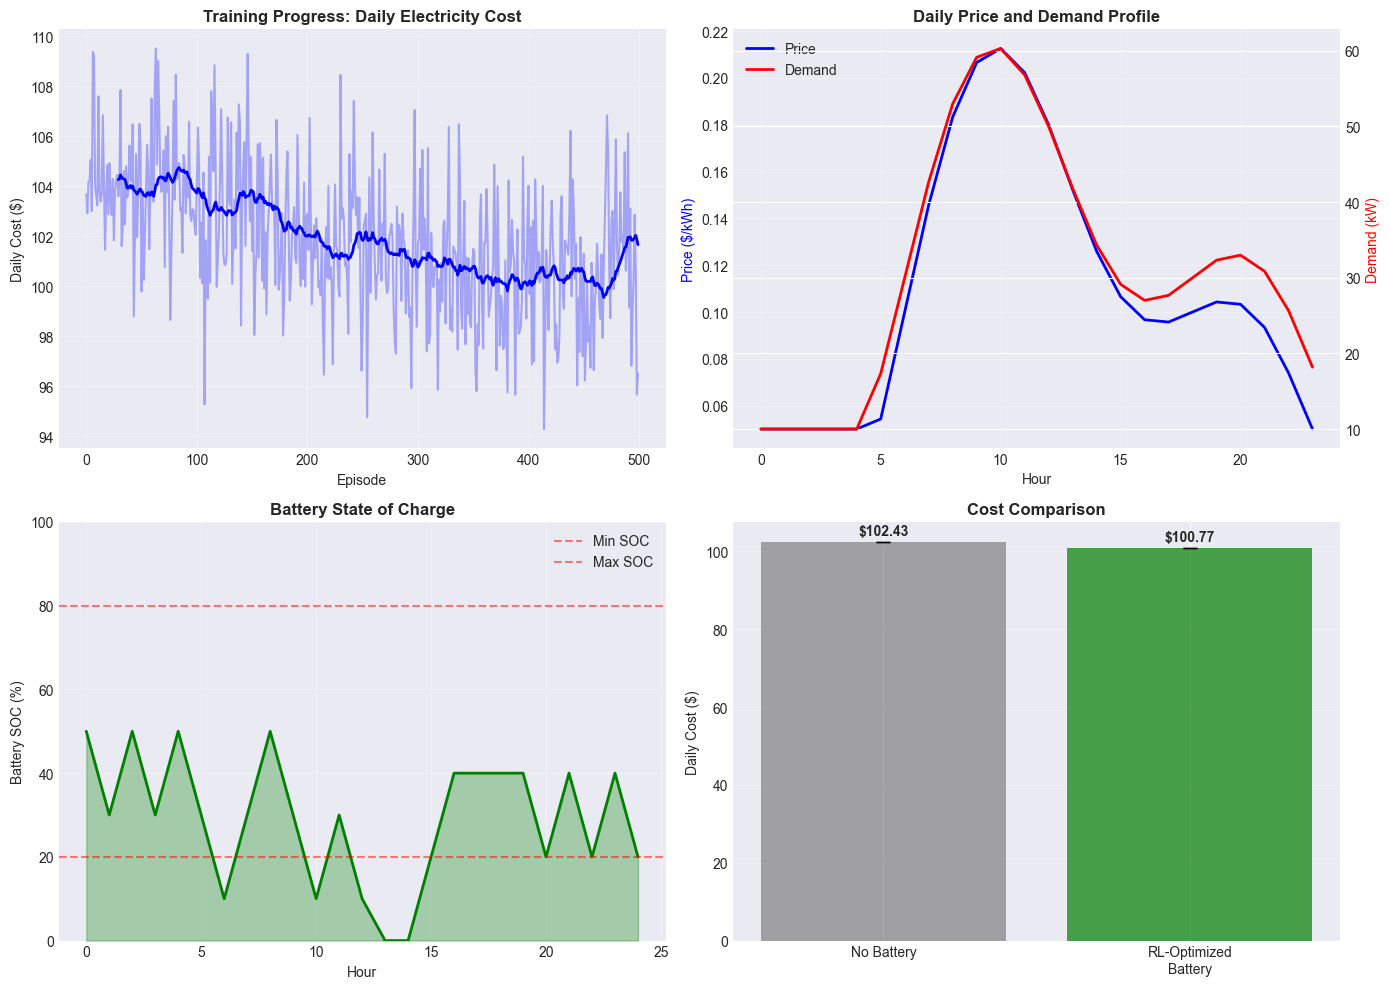


📊 Results Summary:
   Baseline Cost (no battery): $102.43
   RL-Optimized Cost:          $100.77
   Cost Savings:               1.6%

   The agent learns to charge during low-price hours and discharge during peaks!


In [143]:
# Visualize energy management results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training progress
ax1 = axes[0, 0]
ax1.plot(episode_costs, alpha=0.3, color='blue')
window = 30
smoothed = np.convolve(episode_costs, np.ones(window)/window, mode='valid')
ax1.plot(range(window-1, len(episode_costs)), smoothed, color='blue', linewidth=2)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Daily Cost ($)')
ax1.set_title('Training Progress: Daily Electricity Cost', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Run a sample day with trained agent
np.random.seed(123)
state = env.reset()
done = False

while not done:
    action = agent.get_action(state, training=False)
    state, _, done, info = env.step(action)

# Plot 2: Price and demand profiles
ax2 = axes[0, 1]
hours = np.arange(24)
ax2_twin = ax2.twinx()

l1, = ax2.plot(hours, env.prices, 'b-', linewidth=2, label='Price')
l2, = ax2_twin.plot(hours, env.demand, 'r-', linewidth=2, label='Demand')

ax2.set_xlabel('Hour')
ax2.set_ylabel('Price ($/kWh)', color='blue')
ax2_twin.set_ylabel('Demand (kW)', color='red')
ax2.set_title('Daily Price and Demand Profile', fontweight='bold')
ax2.legend([l1, l2], ['Price', 'Demand'], loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Battery operation
ax3 = axes[1, 0]
battery_soc = np.array(env.battery_history) / env.battery_capacity * 100

ax3.fill_between(range(25), battery_soc, alpha=0.3, color='green')
ax3.plot(range(25), battery_soc, 'g-', linewidth=2)
ax3.axhline(y=20, color='red', linestyle='--', alpha=0.5, label='Min SOC')
ax3.axhline(y=80, color='red', linestyle='--', alpha=0.5, label='Max SOC')

ax3.set_xlabel('Hour')
ax3.set_ylabel('Battery SOC (%)')
ax3.set_title('Battery State of Charge', fontweight='bold')
ax3.set_ylim([0, 100])
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Compare with baseline (no storage)
ax4 = axes[1, 1]

# Calculate baseline cost (no battery)
baseline_cost = sum(env.prices * env.demand)

# Run multiple episodes for comparison
rl_costs = []
baseline_costs = []

for _ in range(50):
    state = env.reset()
    done = False
    while not done:
        action = agent.get_action(state, training=False)
        state, _, done, info = env.step(action)
    rl_costs.append(info['total_cost'])
    baseline_costs.append(sum(env.prices * env.demand))

methods = ['No Battery', 'RL-Optimized\nBattery']
means = [np.mean(baseline_costs), np.mean(rl_costs)]
stds = [np.std(baseline_costs), np.std(rl_costs)]

bars = ax4.bar(methods, means, yerr=stds, capsize=5, 
               color=['gray', 'green'], alpha=0.7)
ax4.set_ylabel('Daily Cost ($)')
ax4.set_title('Cost Comparison', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar, mean in zip(bars, means):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'${mean:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

savings = (np.mean(baseline_costs) - np.mean(rl_costs)) / np.mean(baseline_costs) * 100
print(f"\n📊 Results Summary:")
print(f"   Baseline Cost (no battery): ${np.mean(baseline_costs):.2f}")
print(f"   RL-Optimized Cost:          ${np.mean(rl_costs):.2f}")
print(f"   Cost Savings:               {savings:.1f}%")
print(f"\n   The agent learns to charge during low-price hours and discharge during peaks!")

<a id='chess'></a>
### Chess Environment

**Chess as an RL Problem**

Chess has been a benchmark for AI since the field's inception. While Deep Blue (1997) used primarily search-based methods, modern approaches like AlphaZero demonstrate the power of RL combined with deep learning.

**Why Chess is Challenging:**

1. **Enormous State Space**: ~10^44 legal positions
2. **Large Action Space**: Average ~35 legal moves per position
3. **Long-term Planning**: Games can last 40+ moves
4. **Sparse Rewards**: Only win/lose/draw at game end
5. **Perfect Information**: Both players see the full board

**State Representation Challenges:**

| Representation | Pros | Cons |
|----------------|------|------|
| FEN String | Compact, standard | Not neural-network friendly |
| 8x8x12 Tensor | One-hot piece encoding | Large, sparse |
| 8x8x119 (AlphaZero) | Includes history | Very large |
| Graph Neural Network | Captures piece relationships | Complex |

**AlphaZero's Approach:**

- **Self-play**: Generates training data by playing against itself
- **MCTS**: Monte Carlo Tree Search for move selection
- **Neural Network**: Predicts move probabilities and position value
- **No Human Knowledge**: Learns entirely from self-play (except rules)

**Computational Challenges:**

- AlphaZero used 5,000 TPUs for training
- 44 million games of self-play
- 9 hours of training to surpass all previous chess engines

Let's set up a basic chess environment wrapper to understand the interface.

In [144]:
# Chess Environment Setup
# Note: This requires the python-chess library
# Install with: pip install python-chess

import numpy as np

# Try to import chess, provide fallback if not available
try:
    import chess
    CHESS_AVAILABLE = True
except ImportError:
    CHESS_AVAILABLE = False
    print("python-chess not installed. Install with: pip install python-chess")
    print("Showing conceptual implementation instead.\n")


class ChessEnvWrapper:
    """
    Wrapper around python-chess to create an RL-compatible interface.
    
    This demonstrates how to structure a chess environment for RL,
    though training a competitive agent requires significant compute.
    """
    
    def __init__(self):
        if not CHESS_AVAILABLE:
            raise ImportError("python-chess required")
        
        self.board = chess.Board()
        self.move_history = []
    
    def reset(self):
        """Reset to starting position."""
        self.board = chess.Board()
        self.move_history = []
        return self._get_state()
    
    def _get_state(self):
        """
        Convert board to neural network input.
        
        Returns 8x8x12 tensor:
        - 6 planes for white pieces (P, N, B, R, Q, K)
        - 6 planes for black pieces
        """
        state = np.zeros((8, 8, 12), dtype=np.float32)
        
        piece_map = {
            chess.PAWN: 0, chess.KNIGHT: 1, chess.BISHOP: 2,
            chess.ROOK: 3, chess.QUEEN: 4, chess.KING: 5
        }
        
        for square in chess.SQUARES:
            piece = self.board.piece_at(square)
            if piece:
                row = square // 8
                col = square % 8
                plane = piece_map[piece.piece_type]
                if piece.color == chess.BLACK:
                    plane += 6
                state[row, col, plane] = 1.0
        
        return state
    
    def get_legal_moves(self):
        """Return list of legal moves."""
        return list(self.board.legal_moves)
    
    def get_legal_move_mask(self):
        """
        Return mask of legal moves for action space.
        
        Action space: 64 * 64 = 4096 (from_square, to_square)
        Plus promotions, but simplified here.
        """
        mask = np.zeros(4096, dtype=np.float32)
        for move in self.board.legal_moves:
            idx = move.from_square * 64 + move.to_square
            mask[idx] = 1.0
        return mask
    
    def step(self, action):
        """
        Execute a move.
        
        Args:
            action: Either a chess.Move object or (from_sq, to_sq) tuple
        """
        if isinstance(action, tuple):
            from_sq, to_sq = action
            move = chess.Move(from_sq, to_sq)
            # Handle promotion (default to queen)
            if (self.board.piece_at(from_sq) == chess.PAWN and 
                (to_sq // 8 == 0 or to_sq // 8 == 7)):
                move = chess.Move(from_sq, to_sq, promotion=chess.QUEEN)
        else:
            move = action
        
        # Check if move is legal
        if move not in self.board.legal_moves:
            return self._get_state(), -10, True, {'illegal_move': True}
        
        # Make move
        self.board.push(move)
        self.move_history.append(move)
        
        # Check game end
        done = self.board.is_game_over()
        
        if done:
            result = self.board.result()
            if result == '1-0':
                reward = 1 if len(self.move_history) % 2 == 1 else -1
            elif result == '0-1':
                reward = -1 if len(self.move_history) % 2 == 1 else 1
            else:
                reward = 0  # Draw
        else:
            reward = 0
        
        info = {
            'result': self.board.result() if done else None,
            'move': move.uci(),
            'fen': self.board.fen()
        }
        
        return self._get_state(), reward, done, info
    
    def render(self):
        """Print the board."""
        print(self.board)
        print(f"\nFEN: {self.board.fen()}")
        print(f"Legal moves: {len(list(self.board.legal_moves))}")


if CHESS_AVAILABLE:
    print("Chess Environment Wrapper created!")
    print("\nState representation: 8x8x12 tensor")
    print("  - 6 planes for white pieces (P, N, B, R, Q, K)")
    print("  - 6 planes for black pieces")
    print("\nAction space: 4096 (64 from-squares × 64 to-squares)")
else:
    print("Chess environment requires python-chess library.")
    print("The code above shows the structure of a chess RL environment.")

python-chess not installed. Install with: pip install python-chess
Showing conceptual implementation instead.

Chess environment requires python-chess library.
The code above shows the structure of a chess RL environment.


In [145]:
# Demonstrate chess environment (if available)
if CHESS_AVAILABLE:
    env = ChessEnvWrapper()
    state = env.reset()
    
    print("Initial Position:")
    env.render()
    
    print(f"\nState shape: {state.shape}")
    print(f"Number of legal moves: {len(env.get_legal_moves())}")
    
    # Play a few random moves
    print("\n" + "="*50)
    print("Playing 4 random moves...")
    print("="*50)
    
    for i in range(4):
        legal_moves = env.get_legal_moves()
        move = np.random.choice(legal_moves)
        state, reward, done, info = env.step(move)
        print(f"\nMove {i+1}: {info['move']}")
    
    print("\nPosition after 4 moves:")
    env.render()
else:
    print("Skipping demo - python-chess not installed")
    print("\nConceptual overview of chess RL:")
    print("1. State: Board position encoded as tensor")
    print("2. Action: Select from legal moves")
    print("3. Reward: +1 for win, -1 for loss, 0 for draw")
    print("4. Training: Self-play with MCTS + neural network")

Skipping demo - python-chess not installed

Conceptual overview of chess RL:
1. State: Board position encoded as tensor
2. Action: Select from legal moves
3. Reward: +1 for win, -1 for loss, 0 for draw
4. Training: Self-play with MCTS + neural network


**Computational Challenges and Practical Considerations**

Training a competitive chess agent from scratch is computationally prohibitive for most practitioners:

**AlphaZero Resources:**
- 5,000 first-generation TPUs
- 44 million games of self-play
- 9 hours of training
- Estimated cost: $25+ million in compute

**Practical Alternatives:**

1. **Use Pre-trained Models**
   - Leela Chess Zero (Lc0): Open-source AlphaZero implementation
   - Pre-trained weights available
   - Can fine-tune for specific purposes

2. **Simplified Variants**
   - Mini-chess (5x5 or 6x6 boards)
   - Reduced piece sets
   - Faster training, same concepts

3. **Transfer Learning**
   - Start from strong engine evaluations
   - Use supervised learning on grandmaster games
   - Fine-tune with RL

4. **Focus on Specific Aspects**
   - Endgame tablebases
   - Opening book learning
   - Tactical pattern recognition

**Key Takeaways:**

- Chess demonstrates RL's potential for complex strategic reasoning
- Self-play + MCTS + deep learning is a powerful combination
- Computational requirements scale with problem complexity
- Open-source implementations make experimentation accessible

**Resources for Further Exploration:**
- [Leela Chess Zero](https://lczero.org/) - Open-source neural network chess engine
- [python-chess](https://python-chess.readthedocs.io/) - Chess library for Python
- [AlphaZero Paper](https://arxiv.org/abs/1712.01815) - Original DeepMind paper

<a id='section6'></a>
## Section 6: Advanced Research & Deployment

In this final section, we explore the cutting edge of reinforcement learning research and the practical challenges of deploying RL systems in production. We'll cover current research trends, ethical considerations, deployment challenges, and provide a complete end-to-end pipeline for taking RL from research to production.

**What You'll Learn:**
- Current research frontiers in multi-agent RL, meta-learning, and safe RL
- Ethical and safety considerations for deploying RL systems
- Practical challenges in production deployment
- End-to-end pipeline for training, validating, and deploying RL models
- Recent research highlights from top conferences

<a id='research-trends'></a>
### Current Research Trends

The field of reinforcement learning is rapidly evolving. Here we explore the most exciting research directions that are shaping the future of RL.

#### Multi-Agent Reinforcement Learning (MARL)

**What is Multi-Agent RL?**

Multi-Agent Reinforcement Learning extends traditional RL to scenarios where multiple agents interact within a shared environment. Each agent learns its own policy while considering the actions and strategies of other agents.

**Key Challenges:**

1. **Non-Stationarity**: From each agent's perspective, the environment appears non-stationary because other agents are also learning and changing their policies.

2. **Credit Assignment**: In cooperative settings, determining which agent's actions contributed to team success is difficult.

3. **Scalability**: The joint action space grows exponentially with the number of agents.

4. **Equilibrium Selection**: In competitive settings, multiple Nash equilibria may exist.

**Recent Advancements:**

- **QMIX (2018)**: Factorizes the joint action-value function into individual agent utilities while maintaining monotonicity constraints.

- **MAPPO (2021)**: Adapts PPO for multi-agent settings with centralized training and decentralized execution.

- **OpenAI Five (2019)**: Demonstrated superhuman performance in Dota 2 using distributed multi-agent training.

- **AlphaStar (2019)**: Achieved Grandmaster level in StarCraft II using population-based training with multiple agents.

**Mathematical Framework:**

In a Markov Game (multi-agent MDP), we have:
- $N$ agents with individual action spaces $\mathcal{A}_1, ..., \mathcal{A}_N$
- Joint action $\mathbf{a} = (a_1, ..., a_N)$
- Individual reward functions $r_i(s, \mathbf{a})$
- Transition function $P(s' | s, \mathbf{a})$

Each agent $i$ aims to maximize:

$J_i(\pi_i) = \mathbb{E}_{\pi_1,...,\pi_N}\left[\sum_{t=0}^{\infty} \gamma^t r_i(s_t, \mathbf{a}_t)\right]$

#### Curriculum Learning in RL

**What is Curriculum Learning?**

Curriculum learning is a training strategy where an agent learns from a sequence of progressively more difficult tasks, similar to how humans learn. Instead of immediately tackling the hardest version of a problem, the agent starts with simpler versions and gradually advances.

**Why It Matters:**

- **Faster Learning**: Starting with easier tasks provides more frequent rewards, accelerating initial learning.
- **Better Exploration**: Simpler tasks help the agent discover useful behaviors before facing complex challenges.
- **Improved Final Performance**: Gradual difficulty increase often leads to better policies than training on hard tasks directly.

**Types of Curricula:**

1. **Hand-Designed Curricula**: Domain experts manually design the progression of tasks.

2. **Automatic Curriculum Learning (ACL)**: The curriculum is generated automatically based on agent performance.

3. **Self-Play Curricula**: Agents create their own curriculum by playing against past versions of themselves.

**Key Methods:**

- **POET (2019)**: Paired Open-Ended Trailblazer - co-evolves environments and agents.
- **PLR (2020)**: Prioritized Level Replay - prioritizes training on levels where the agent struggles.
- **ACCEL (2022)**: Automatic Curriculum via Evolution of Learnable environments.

**Example: Learning to Walk**

A curriculum for teaching a robot to walk might progress:
1. Standing balance on flat ground
2. Taking single steps
3. Walking on flat terrain
4. Walking on uneven terrain
5. Walking while carrying loads
6. Running and jumping

#### Meta-Reinforcement Learning

**What is Meta-RL?**

Meta-reinforcement learning, or "learning to learn," trains agents that can quickly adapt to new tasks with minimal experience. Instead of learning a single policy, meta-RL learns a learning algorithm or adaptation mechanism.

**The Meta-Learning Objective:**

Given a distribution of tasks $p(\mathcal{T})$, meta-RL optimizes:

$\theta^* = \arg\max_\theta \mathbb{E}_{\mathcal{T} \sim p(\mathcal{T})}\left[J(\theta, \mathcal{T})\right]$

where $J(\theta, \mathcal{T})$ is the expected return on task $\mathcal{T}$ after adaptation.

**Key Approaches:**

1. **Recurrent Meta-RL**: Uses RNNs to encode task information in hidden states.
   - RL² (2016): Treats the entire learning process as an RNN rollout.

2. **Gradient-Based Meta-RL**: Learns initial parameters that can be quickly fine-tuned.
   - MAML (2017): Model-Agnostic Meta-Learning - learns initialization for fast adaptation.

3. **Context-Based Meta-RL**: Learns to infer task context from experience.
   - PEARL (2019): Probabilistic Embeddings for Actor-critic RL.

**Applications:**

- **Robotics**: Quickly adapting to new objects or environments
- **Personalization**: Adapting to individual user preferences
- **Sim-to-Real Transfer**: Adapting simulation-trained policies to real-world dynamics

#### Safe Reinforcement Learning

**The Safety Challenge:**

Traditional RL optimizes for reward without considering safety constraints. In real-world applications (autonomous vehicles, medical treatment, industrial control), unsafe exploration can have catastrophic consequences.

**Key Challenges in Sensitive Areas:**

1. **Healthcare**: Wrong treatment decisions can harm patients
2. **Autonomous Vehicles**: Unsafe actions can cause accidents
3. **Financial Systems**: Poor decisions can cause significant losses
4. **Industrial Control**: Unsafe operations can damage equipment or harm workers

**Approaches to Safe RL:**

1. **Constrained MDPs (CMDPs)**:
   - Add constraints to the optimization problem
   - $\max_\pi J(\pi)$ subject to $C_i(\pi) \leq d_i$ for safety constraints $C_i$

2. **Risk-Sensitive RL**:
   - Optimize risk-adjusted returns (CVaR, variance-penalized)
   - $\max_\pi \mathbb{E}[R] - \lambda \cdot \text{Var}[R]$

3. **Shielding**:
   - Use a safety layer that overrides unsafe actions
   - Formal verification of safety properties

4. **Safe Exploration**:
   - Constrained Policy Optimization (CPO)
   - Lyapunov-based methods for stability guarantees

**Recent Methods:**

- **CPO (2017)**: Constrained Policy Optimization with trust region constraints
- **LAMBDA (2020)**: Lagrangian-based safe RL with automatic constraint satisfaction
- **Recovery RL (2021)**: Learns a recovery policy to return to safe states

#### Interpretability in Reinforcement Learning

**Why Interpretability Matters:**

As RL systems are deployed in high-stakes domains, understanding *why* an agent makes certain decisions becomes crucial for:

- **Trust**: Users need to understand and trust the system's decisions
- **Debugging**: Identifying and fixing problematic behaviors
- **Compliance**: Meeting regulatory requirements (e.g., GDPR's right to explanation)
- **Safety**: Verifying that the agent behaves safely in edge cases

**Approaches to Interpretable RL:**

1. **Attention Mechanisms**:
   - Visualize what parts of the state the agent focuses on
   - Saliency maps for visual inputs

2. **Policy Distillation**:
   - Train interpretable models (decision trees, rule lists) to mimic complex policies
   - Trade-off between interpretability and performance

3. **Reward Decomposition**:
   - Break down the reward into interpretable components
   - Understand which factors drive agent behavior

4. **Concept-Based Explanations**:
   - Map agent decisions to human-understandable concepts
   - "The agent chose action X because it detected concept Y"

5. **Counterfactual Explanations**:
   - "The agent would have chosen differently if..."
   - Identify minimal changes that would alter decisions

**Challenges:**

- Deep RL policies are inherently complex and non-linear
- Temporal credit assignment makes explanations difficult
- Trade-off between model complexity and interpretability

#### Reinforcement Learning in Natural Language Processing

**The Role of RL in NLP:**

RL has become increasingly important in NLP, particularly for:

1. **Dialogue Systems**: Training conversational agents to maximize user satisfaction

2. **Text Generation**: Optimizing for non-differentiable metrics (BLEU, ROUGE)

3. **Machine Translation**: Fine-tuning translation quality beyond cross-entropy loss

4. **Large Language Model Alignment**: RLHF (Reinforcement Learning from Human Feedback)

**RLHF: Aligning Language Models**

RLHF has become the dominant paradigm for aligning large language models with human preferences:

1. **Supervised Fine-Tuning (SFT)**: Train on high-quality demonstrations

2. **Reward Model Training**: Train a model to predict human preferences
   - Given pairs of responses, predict which humans prefer

3. **RL Fine-Tuning**: Use PPO to optimize the language model against the reward model
   - $\max_\pi \mathbb{E}_{x \sim D, y \sim \pi}[r(x, y)] - \beta \cdot D_{KL}[\pi || \pi_{ref}]$

**Key Applications:**

- **ChatGPT/GPT-4**: Uses RLHF for helpful, harmless, and honest responses
- **Claude**: Constitutional AI with RL from AI feedback
- **Gemini**: Multi-modal alignment using RL techniques

**Challenges:**

- Reward hacking: Models may exploit reward model weaknesses
- Distribution shift: Generated text may differ from training distribution
- Scalability: RLHF is computationally expensive

#### Key Research References

**Multi-Agent RL:**
- Rashid et al. (2018). "QMIX: Monotonic Value Function Factorisation for Deep Multi-Agent Reinforcement Learning." ICML.
- Yu et al. (2021). "The Surprising Effectiveness of PPO in Cooperative Multi-Agent Games." NeurIPS.

**Curriculum Learning:**
- Wang et al. (2019). "POET: Open-Ended Coevolution of Environments and their Optimized Solutions." GECCO.
- Jiang et al. (2021). "Prioritized Level Replay." ICML.

**Meta-RL:**
- Finn et al. (2017). "Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks." ICML.
- Rakelly et al. (2019). "Efficient Off-Policy Meta-Reinforcement Learning via Probabilistic Context Variables." ICML.

**Safe RL:**
- Achiam et al. (2017). "Constrained Policy Optimization." ICML.
- Ray et al. (2019). "Benchmarking Safe Exploration in Deep Reinforcement Learning." OpenAI.

**RLHF:**
- Ouyang et al. (2022). "Training language models to follow instructions with human feedback." NeurIPS.
- Bai et al. (2022). "Constitutional AI: Harmlessness from AI Feedback." Anthropic.

<a id='ethics'></a>
### Ethical and Safety Considerations

As RL systems become more powerful and widely deployed, ethical considerations become paramount. This section explores the key ethical challenges and frameworks for responsible RL development.

#### Ethical Concerns in RL Deployment

**Key Ethical Issues:**

1. **Autonomy and Control**
   - RL agents make decisions without human oversight
   - Who is responsible when an autonomous system causes harm?
   - How much autonomy should we grant to RL systems?

2. **Transparency and Explainability**
   - Deep RL policies are often "black boxes"
   - Users may not understand why decisions are made
   - Regulatory requirements for explainability (GDPR Article 22)

3. **Privacy Concerns**
   - RL systems often require extensive data collection
   - Personalization systems learn detailed user profiles
   - Data retention and usage policies

4. **Dual Use Concerns**
   - RL techniques can be used for beneficial or harmful purposes
   - Autonomous weapons systems
   - Manipulation and persuasion systems

5. **Environmental Impact**
   - Training large RL models requires significant compute
   - Carbon footprint of RL research and deployment
   - Need for more sample-efficient algorithms

**Case Study: Recommendation Systems**

RL-powered recommendation systems raise several ethical concerns:
- **Filter Bubbles**: Optimizing for engagement may limit exposure to diverse viewpoints
- **Addiction**: Systems may exploit psychological vulnerabilities to maximize engagement
- **Misinformation**: Engagement-optimized systems may promote sensational but false content
- **Privacy**: Detailed user modeling for personalization

#### The Alignment Problem

**What is the Alignment Problem?**

The alignment problem refers to the challenge of ensuring that AI systems' objectives and behaviors align with human values and intentions. In RL, this manifests as the difficulty of specifying reward functions that capture what we truly want.

**Why Alignment is Difficult:**

1. **Reward Specification**
   - Human values are complex and context-dependent
   - Difficult to encode all relevant considerations in a reward function
   - Goodhart's Law: "When a measure becomes a target, it ceases to be a good measure"

2. **Reward Hacking**
   - Agents find unintended ways to maximize reward
   - Example: A cleaning robot might hide dirt instead of cleaning it
   - Example: A game-playing agent might exploit bugs rather than play skillfully

3. **Distributional Shift**
   - Agents may behave unexpectedly in situations not covered by training
   - Real-world deployment differs from training environments

4. **Mesa-Optimization**
   - Learned policies may develop internal objectives that differ from the training objective
   - These internal objectives may be misaligned with human values

**Approaches to Alignment:**

1. **Inverse Reinforcement Learning (IRL)**
   - Learn reward functions from human demonstrations
   - Infer what humans value from their behavior

2. **Reward Modeling**
   - Train models to predict human preferences
   - RLHF uses this approach for language model alignment

3. **Constitutional AI**
   - Define principles that the AI should follow
   - Use AI feedback to enforce these principles

4. **Debate and Amplification**
   - Use AI systems to help humans evaluate AI behavior
   - Scale human oversight through AI assistance

5. **Corrigibility**
   - Design agents that allow themselves to be corrected
   - Avoid agents that resist shutdown or modification

#### Fairness and Bias Considerations

**Sources of Bias in RL:**

1. **Training Data Bias**
   - Historical data may reflect past discrimination
   - Underrepresentation of certain groups
   - Example: Healthcare RL trained on biased treatment data

2. **Reward Function Bias**
   - Reward functions may implicitly favor certain groups
   - Proxy metrics may correlate with protected attributes
   - Example: Optimizing for "engagement" may disadvantage certain demographics

3. **Simulation Bias**
   - Simulated environments may not accurately represent all populations
   - Sim-to-real transfer may work better for some groups than others

4. **Feedback Loop Bias**
   - RL systems can amplify existing biases through feedback loops
   - Example: Predictive policing concentrating resources in already over-policed areas

**Fairness Definitions:**

Several mathematical definitions of fairness exist, often in tension:

1. **Demographic Parity**: Equal positive outcome rates across groups
   - $P(\hat{Y}=1|A=0) = P(\hat{Y}=1|A=1)$

2. **Equalized Odds**: Equal true positive and false positive rates
   - $P(\hat{Y}=1|Y=y,A=0) = P(\hat{Y}=1|Y=y,A=1)$ for $y \in \{0,1\}$

3. **Individual Fairness**: Similar individuals should be treated similarly
   - $d(f(x_1), f(x_2)) \leq L \cdot d(x_1, x_2)$

**Mitigation Strategies:**

1. **Pre-processing**: Remove or transform biased features
2. **In-processing**: Add fairness constraints to the RL objective
3. **Post-processing**: Adjust outputs to satisfy fairness criteria
4. **Auditing**: Regular testing for disparate impact across groups

**Case Study: Healthcare RL**

An RL system for treatment recommendations must consider:
- Historical treatment disparities in training data
- Different baseline health outcomes across demographics
- Access to healthcare affecting data availability
- Ensuring equitable treatment recommendations across all patient groups

#### Case Studies in RL Ethics

**Case Study 1: Autonomous Vehicles**

RL-trained autonomous vehicles face ethical dilemmas:
- **Trolley Problem Scenarios**: How should the car behave in unavoidable accident situations?
- **Risk Distribution**: Should the car prioritize passenger safety over pedestrian safety?
- **Transparency**: Should passengers know how the car makes decisions?
- **Liability**: Who is responsible for accidents - manufacturer, owner, or algorithm?

**Case Study 2: Content Moderation**

RL systems for content moderation must balance:
- **Free Speech**: Avoiding over-censorship of legitimate content
- **Harm Prevention**: Removing genuinely harmful content
- **Cultural Context**: Different norms across regions and communities
- **Consistency**: Applying rules fairly across all users

**Case Study 3: Financial Trading**

RL trading systems raise concerns about:
- **Market Stability**: Could RL agents cause flash crashes?
- **Fairness**: Do RL systems give unfair advantages to wealthy institutions?
- **Manipulation**: Could RL agents learn to manipulate markets?
- **Systemic Risk**: What happens when many RL agents interact?

**Best Practices for Ethical RL Development:**

1. **Diverse Teams**: Include ethicists, domain experts, and affected communities
2. **Impact Assessment**: Evaluate potential harms before deployment
3. **Monitoring**: Continuously monitor for unintended consequences
4. **Feedback Mechanisms**: Allow users to report problems
5. **Graceful Degradation**: Design systems that fail safely
6. **Documentation**: Maintain clear records of design decisions and their rationale

<a id='deployment'></a>
### Deployment Challenges

Deploying RL systems in production presents unique challenges beyond traditional ML. This section covers the key obstacles and best practices for successful RL deployment.